# Hierarchical Linear Regression in Edward2

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
import warnings

from tensorflow_probability import edward2 as ed

data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values

/Users/twiecki/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/twiecki/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullar

/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()


The relevant part of the data we will model looks as follows:

In [2]:
data[['county', 'log_radon', 'floor']].head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


In [8]:
def model(data):
    county_idx = data['county_code'].values
    
    # Set up random effects.
    grp_mu_intercept = ed.Normal(
      loc=0.,
      scale=1.,
      name="grp_mu_intercept")
    
    grp_sd_intercept = ed.HalfNormal(
      scale=1.,
      name="grp_sd_intercept")

    grp_mu_slope = ed.Normal(
      loc=0.,
      scale=1.,
      name="grp_mu_slope")
    
    grp_sd_slope = ed.HalfNormal(
      scale=1.,
      name="grp_sd_slope")

    intercept = ed.MultivariateNormalDiag(
        loc=tf.ones(len(data.county.unique())) * grp_mu_intercept,
        scale_identity_multiplier=grp_sd_intercept,
        name='intercept',
    )
    
    slope = ed.MultivariateNormalDiag(
        loc=tf.ones(len(data.county.unique())) * grp_mu_slope,
        scale_identity_multiplier=grp_sd_slope,
        name='slope',
    )

    radon = ed.Normal(
        loc=(tf.gather(intercept, county_idx) +
             tf.gather(slope, county_idx) * data.floor.values),
        scale=1.,
        name='radon',
    )

    return radon

# Wrap model in a template. All calls to the model template will use the same
# TensorFlow variables.
model_template = tf.make_template("model", model)

In [11]:
log_joint = ed.make_log_joint_fn(model_template)

def target_log_prob_fn(grp_mu_intercept,
                       grp_sd_intercept,
                       grp_mu_slope,
                       grp_sd_slope,
                       intercept,
                       slope,                       
                      ):
    """Unnormalized target density as a function of states."""
    return log_joint(
        data=data,
        grp_mu_intercept=grp_mu_intercept,
        grp_sd_intercept=grp_sd_intercept,
        grp_mu_slope=grp_mu_slope,
        grp_sd_slope=grp_sd_slope,      
        intercept=intercept,
        slope=slope,
        radon=data.log_radon.values)

In [5]:
grp_mu_intercept = tf.get_variable('grp_mu_intercept', ())
grp_sd_intercept = tf.get_variable('grp_sd_intercept', ())
grp_mu_slope = tf.get_variable('grp_mu_slope', ())
grp_sd_slope = tf.get_variable('grp_sd_slope', ())    
intercept = tf.get_variable('intercept', len(data.county.unique()))
slope = tf.get_variable('slope', len(data.county.unique()))

In [6]:
current_state = [grp_mu_intercept, grp_sd_intercept, grp_mu_slope, grp_sd_slope, intercept, slope]

In [50]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

with sess.as_default():
    states, kernel_results = tfp.mcmc.sample_chain(
      num_results=1000,
      current_state=current_state,
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.01,
        num_leapfrog_steps=3),
      num_burnin_steps=500)
    
    trace = {rv.name: states[i].eval() for i, rv in enumerate(current_state)}

/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow_probability/python/edward2/program_transformations.py:132: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argspec = inspect.getargspec(f._func)  # pylint: disable=protected-access
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.sig

/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()


/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()


/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()


/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/twiecki/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


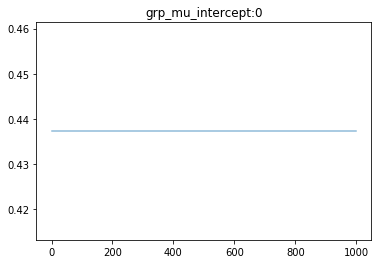

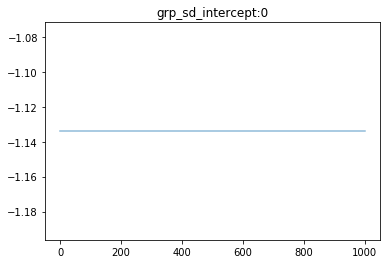

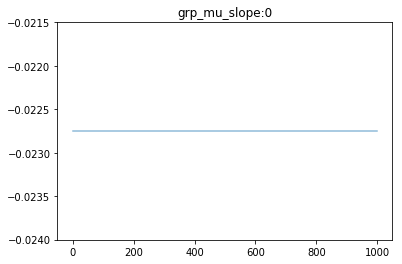

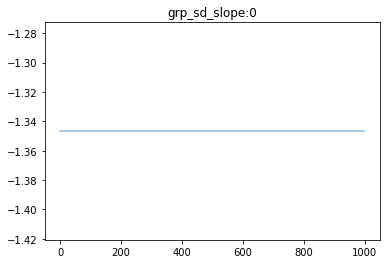

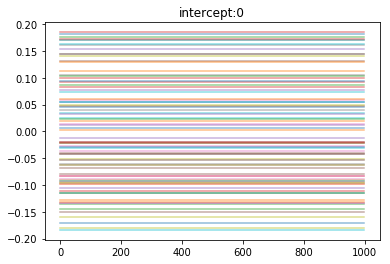

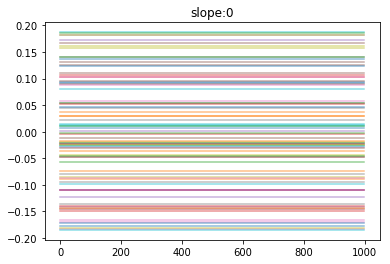

In [51]:
for name, tr in trace.items():
    plt.figure()
    plt.plot(tr, alpha=.5)
    plt.title(name)